# Experiment 17: 17_denoising_pretraining

Average Test Dice: 0.668

Public Leaderboard Score: 0.64

No improvement from 16

In [1]:
EXP_NAME = "17_denoising_pretraining"

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import monai
from typing import Union, Tuple, Any
from pathlib import Path
Path.ls = lambda p: list(p.iterdir())
from functools import partial
from fastai.data.transforms import get_image_files
from fastcore.foundation import L
import catalyst
from catalyst import dl
import segmentation_models_pytorch as smp
import albumentations as A

# Lookahead imports
from typing import Callable, Dict, Optional
from collections import defaultdict
import torch
from torch.optim import Optimizer

In [3]:
def get_device(verbose: bool = True) -> torch.device:
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        if verbose: print("Using the GPU!")
    else:
        device = torch.device("cpu")
        if verbose: print("Using the CPU!")
    return device
    
def load_image_monai(fn: Union[Path, str]) -> np.array:
    image_array = monai.transforms.LoadImage(image_only=True)(str(fn))
    return image_array.__array__().astype(np.uint8)

def plot_image_mask(image: np.array, mask: np.array, figsize: Tuple[int, int] = (10, 10)):
    if not isinstance(image, type(np.array([0]))): image = image.detach().cpu().numpy()
    if not isinstance(mask, type(np.array([0]))): mask = mask.detach().cpu().numpy()
    if len(image.shape) == 3 and image.shape[0] == 3: image = image.transpose(1, 2, 0)
    if len(mask.shape) == 3 and mask.shape[0] > 1: mask = mask[0]
    plt.figure(figsize=figsize)
    if image.mean() > 1: plt.imshow(image.astype(np.uint8), interpolation="none")
    else: plt.imshow(image.astype(np.float32), interpolation="none")
    plt.imshow(mask.astype(np.uint8), cmap="jet", alpha=0.5)
    
def plot_image(image: np.array, figsize: Tuple[int, int] = (10, 10)):
    if not isinstance(image, type(np.array([0]))): image = image.detach().cpu().numpy()
    if len(image.shape) == 3 and image.shape[0] == 3: image = image.transpose(1, 2, 0)
    plt.figure(figsize=figsize)
    plt.imshow(image, interpolation="none")

def fn2image(fn: Union[Path, str]) -> np.array:
    return load_image_monai(fn)

def id2image(fid: str) -> np.array:
    fn = id2fn(fid)
    return fn2image(fn)

def fn2id(fn: Union[Path, str]) -> str:
    return str(fn).split("/")[-1].split(".")[0]

def id2image(fid: str) -> np.array:
    fn = id2fn(fid)
    return fn2image(fn)

def fn2id(fn: Union[Path, str]) -> str:
    return str(fn).split("/")[-1].split(".")[0]

def id2fn(fid: str) -> Path:
    return COMBINED_DF[COMBINED_DF.id == int(fid)]["fnames"].values[0]

def id2rle(fid: str) -> str:
    rle = TRAIN_DF[TRAIN_DF.id==int(fid)]["rle"].values[0]
    return rle

def fn2rle(fn: Union[Path, str]) -> str:
    fid = fn2id(fn)
    return id2rle(fid)

def id2organ(fid: str) -> str:
    organ = TRAIN_DF[TRAIN_DF.id==int(fid)]["organ"].values[0]
    return organ

def id2shape(fid: str) -> Tuple[int, int]:
    width = COMBINED_DF[COMBINED_DF.id==int(fid)]["img_width"].values[0]
    height = COMBINED_DF[COMBINED_DF.id==int(fid)]["img_height"].values[0]
    return width, height

def fn2shape(fn: Union[Path, str]) -> Tuple[int, int]:
    fid = fn2id(fn)
    return id2shape(fid)

def load_mask(fn: Union[Path, str]) -> np.array:
    shape = fn2shape(fn)
    rle = fn2rle(fn)
    return rle_decode(rle, shape)

def fn2mask(fn: Union[Path, str]) -> np.array:
    return load_mask(fn)

def id2mask(fid: str) -> np.array:
    fn = id2fn(fid)
    return fn2mask(fn)

def save_df(df:Dict[str, Any], df_file:str, replace:bool=False):
    if replace: return pd.DataFrame(df).to_csv(df_file, index=False)
    try: 
        d = pd.read_csv(df_file)
        d = pd.concat([d, pd.DataFrame(df)])
    except FileNotFoundError: 
        d = pd.DataFrame(df)
    d.to_csv(df_file, index=False)

def load_df(df_file: str) -> pd.DataFrame:
    try:  df = pd.read_csv(df_file)
    except FileNotFoundError: df = None
    return df

def calc_metric(
        y_hat:torch.Tensor,
        y:torch.Tensor,
        metric_func:callable,
        process_logits:callable=monai.transforms.Compose([
                monai.transforms.EnsureType(), 
                monai.transforms.Activations(softmax=True),
                monai.transforms.AsDiscrete(argmax=True)
            ])) -> float:
    y_hat = [process_logits(i) for i in monai.data.decollate_batch(y_hat)]
    y = [i for i in monai.data.decollate_batch(y)]
    metric = metric_func(y_hat, y)
    metric = metric_func.aggregate().item()
    metric_func.reset()
    return metric

In [4]:
# From: https://www.kaggle.com/code/paulorzp/run-length-encode-and-decode/script
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return np.reshape(img, shape)
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [5]:
def split_df_train_test(df, colname, seed=9210, test_pct=0.2):
    df = df.copy()
    np.random.seed(seed)
    indices = np.arange(len(df))
    np.random.shuffle(indices)
    test_ids = df.id.values[indices[:int(test_pct*len(indices))]]
    df[colname] = df.id.apply(lambda fid: fid in test_ids)
    return df

In [6]:
class Lookahead(Optimizer):
    """Implements Lookahead algorithm.

    It has been proposed in `Lookahead Optimizer: k steps forward,
    1 step back`_.

    Main origins of inspiration:
        https://github.com/alphadl/lookahead.pytorch (MIT License)

    .. _`Lookahead Optimizer\: k steps forward, 1 step back`:
        https://arxiv.org/abs/1907.08610
    """

    def __init__(self, optimizer: Optimizer, k: int = 5, alpha: float = 0.5):
        """@TODO: Docs. Contribution is welcome."""
        self.optimizer = optimizer
        self.k = k
        self.alpha = alpha
        self.param_groups = self.optimizer.param_groups
        self.defaults = self.optimizer.defaults
        self.state = defaultdict(dict)
        self.fast_state = self.optimizer.state
        for group in self.param_groups:
            group["counter"] = 0


    def update(self, group):
        """@TODO: Docs. Contribution is welcome."""
        for fast in group["params"]:
            param_state = self.state[fast]
            if "slow_param" not in param_state:
                param_state["slow_param"] = torch.zeros_like(fast.data)
                param_state["slow_param"].copy_(fast.data)
            slow = param_state["slow_param"]
            slow += (fast.data - slow) * self.alpha
            fast.data.copy_(slow)


    def update_lookahead(self):
        """@TODO: Docs. Contribution is welcome."""
        for group in self.param_groups:
            self.update(group)


    def step(self, closure: Optional[Callable] = None):
        """Makes optimizer step.

        Args:
            closure (callable, optional): A closure that reevaluates
                the model and returns the loss.
        """
        loss = self.optimizer.step(closure)
        for group in self.param_groups:
            if group["counter"] == 0:
                self.update(group)
            group["counter"] += 1
            if group["counter"] >= self.k:
                group["counter"] = 0
        return loss


    def state_dict(self):
        """@TODO: Docs. Contribution is welcome."""
        fast_state_dict = self.optimizer.state_dict()
        slow_state = {
            (id(k) if isinstance(k, torch.Tensor) else k): v
            for k, v in self.state.items()
        }
        fast_state = fast_state_dict["state"]
        param_groups = fast_state_dict["param_groups"]
        return {
            "fast_state": fast_state,
            "slow_state": slow_state,
            "param_groups": param_groups,
        }


    def load_state_dict(self, state_dict):
        """@TODO: Docs. Contribution is welcome."""
        slow_state_dict = {
            "state": state_dict["slow_state"],
            "param_groups": state_dict["param_groups"],
        }
        fast_state_dict = {
            "state": state_dict["fast_state"],
            "param_groups": state_dict["param_groups"],
        }
        super(Lookahead, self).load_state_dict(slow_state_dict)
        self.optimizer.load_state_dict(fast_state_dict)
        self.fast_state = self.optimizer.state


    def add_param_group(self, param_group):
        """@TODO: Docs. Contribution is welcome."""
        param_group["counter"] = 0
        self.optimizer.add_param_group(param_group)


    @classmethod
    def get_from_params(
        cls, params: Dict, base_optimizer_params: Dict = None, **kwargs,
    ) -> "Lookahead":
        """@TODO: Docs. Contribution is welcome."""
        from catalyst.dl.registry import OPTIMIZERS

        base_optimizer = OPTIMIZERS.get_from_params(
            params=params, **base_optimizer_params
        )
        optimizer = cls(optimizer=base_optimizer, **kwargs)
        return optimizer

In [7]:
TRAIN_DF = pd.read_csv("../data/train.csv")
TEST_DF = pd.read_csv("../data/test.csv")

TRAIN_IMAGES = get_image_files("../data/train_images")
TEST_IMAGES = get_image_files("../data/test_images")
ALL_IMAGES = [*TRAIN_IMAGES, *TEST_IMAGES]

In [8]:
KEYS = ["image", "label"]
IMAGE = "image"
LABEL = "label"
DEVICE = get_device()
TRANSFORM_PROB = 0.5
CROP_SIZE = (2700, 2700)
IMAGE_SIZE = (512, 512)
MIN_CROP_SIZE = (160, 160) # Smallest imagesize in hidden testset (https://www.kaggle.com/competitions/hubmap-organ-segmentation/data)
EPOCHS = 200
ACCUM_STEPS = 1
BATCH_SIZE = 8
LR_BS = 4.6875e-05
LR = LR_BS * BATCH_SIZE * ACCUM_STEPS
EARLY_STOP_PATIENCE = 100
ENCODER = "efficientnet-b5"
GAUSS_STD = 0.8 * IMAGE_SIZE[0] / 1000 

LOG_DIR = Path("../logs")/EXP_NAME
LOG_DIR.mkdir(exist_ok=True)

Using the GPU!


In [9]:
def add_fnames(df:pd.DataFrame)->pd.DataFrame:
    df = df.copy()
    fnames = []
    for fid in df.id.values: fnames.append([fname for fname in ALL_IMAGES if str(fid) in fname.stem][0])
    df["fnames"] = fnames
    return df

def test_model(
        model:torch.nn.Module, 
        dl:monai.data.DataLoader, 
        metric_func:callable, 
        threshold:float=0.5) -> float:
    logit_process = monai.transforms.Compose([
        monai.transforms.EnsureType(), 
        monai.transforms.Activations(softmax=True),
        monai.transforms.AsDiscrete(threshold=threshold)
    ])
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for data in tqdm(iter(dl), total=len(dl)):
            X, y = data[IMAGE].to(DEVICE), data[LABEL]
            y_hat = model(X).detach().cpu()
            preds = [*preds, *[logit_process(i) for i in y_hat]]
            trues = [*trues, *[i for i in monai.data.decollate_batch(y)]]
    metric_func(preds, trues)
    metric = metric_func.aggregate().item()
    metric_func.reset()
    return metric

def load_weights(model:torch.nn.Module, weights_path:Union[str,Path], device:torch.device=DEVICE)->torch.nn.Module:
    state_dict = torch.load(weights_path, map_location=device)
    model.load_state_dict(state_dict)
    return model.to(device)

def make3D(t: np.array) -> np.array:
    t = np.expand_dims(t, axis=2)
    t = np.concatenate((t,t,t), axis=2)
    return t

def plot_results(model, dl, threshold=0.5, figsize=10):
    logit_process = monai.transforms.Compose([
        monai.transforms.EnsureType(), 
        monai.transforms.Activations(softmax=True),
        monai.transforms.AsDiscrete(threshold=threshold)
    ])
    max_size = 2**16
    model = model.to(DEVICE)
    model.eval()
    ims, preds, labels = [], [], []
    with torch.no_grad():
        for item in tqdm(iter(dl), total=len(dl)):
            X, y = item[IMAGE].to(DEVICE), item[LABEL].cpu()
            y_hat = model(X).detach().cpu()
            ims = [*ims, *[im.numpy() for im in X.detach().cpu()]]
            preds = [*preds, *[logit_process(pred).numpy() for pred in y_hat]]
            labels = [*labels, *[lbl.numpy() for lbl in y]]
    
    vs = []
    for i, b in enumerate(range(len(preds))):
        if (i+1) * preds[0].shape[1] * figsize > max_size:
            print("Dataset to big, only displaying a portion of it!")
            break
        
        im = np.einsum("cwh->whc", ims[b])
        pred = make3D(preds[b][1])
        label = make3D(labels[b][1])
        vs.append(np.hstack((im, pred, label)))
    

    plt.figure(figsize=(figsize, figsize*len(vs)))
    plt.title("Input / Prediction / Target")
    plt.imshow(np.vstack(vs))

def one_batch(
        dl:monai.data.DataLoader, 
        b_idx:int=0, 
        unpacked:bool=False) -> Union[Dict[str, Any], Tuple[torch.Tensor, torch.Tensor]]:
    assert b_idx < len(dl), f"DataLoader only has {len(dl)} batches..."
    for i, items in enumerate(iter(dl)):
        if i == b_idx: 
            if unpacked:
                X, y = items[IMAGE].to(DEVICE), items[LABEL].to(DEVICE)
                return X, y
            return items
def batch2numpy(batch:Dict[str,torch.Tensor])->Tuple[np.array]:
    return batch[IMAGE].detach().cpu().numpy(), batch[LABEL].detach().cpu().numpy()
def plot_batch(batch:Dict[str, torch.Tensor], figsize:int=10):
    X, y = batch2numpy(batch)
    vstacks = []
    for b in range(X.shape[0]):
        im = X[b].transpose(1, 2, 0)
        msk = make3D(y[b, 1])
        vstacks.append(np.hstack((im,msk)))
    patchwork = np.vstack(vstacks)
    plt.figure(figsize=(figsize, figsize*X.shape[0]))
    plt.imshow(patchwork)

In [10]:
TRAIN_DF = add_fnames(TRAIN_DF)
TEST_DF = add_fnames(TEST_DF)
COMBINED_DF = pd.concat([TRAIN_DF, TEST_DF])
COMBINED_DF.drop(columns="rle").head(2)

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,age,sex,fnames
0,10044,prostate,HPA,3000,3000,0.4,4,37.0,Male,../data/train_images/10044.tiff
1,10274,prostate,HPA,3000,3000,0.4,4,76.0,Male,../data/train_images/10274.tiff


In [11]:
def add_gaussian_noise(arr):
    noisy_arr = arr + torch.randn(*arr.shape)*GAUSS_STD
    return noisy_arr.to(arr.dtype)

def get_noisy_transforms()->monai.transforms.Compose:
    return monai.transforms.Compose([
        # Load the same image in 'image' and 'label' 
        monai.transforms.Lambdad(KEYS, fn2image),
        monai.transforms.TransposeD(KEYS, (2, 0, 1)),
        monai.transforms.ScaleIntensityD(KEYS),
        monai.transforms.RandSpatialCropd(KEYS, roi_size=MIN_CROP_SIZE),
        monai.transforms.ResizeD(KEYS, spatial_size=IMAGE_SIZE, mode=("bilinear", "bilinear")),
        monai.transforms.RandRotated(KEYS, range_x=np.pi, prob=1, padding_mode="reflection"),
        monai.transforms.Lambdad(IMAGE, add_gaussian_noise),
        monai.transforms.EnsureTypeD(KEYS)
    ])

In [12]:
def plot_image_noisy_image(noise_im, im, figsize=10):
    noise_im, im = noise_im.numpy(), im.numpy()
    noise_im, im = noise_im.transpose(1, 2, 0), im.transpose(1, 2, 0)
    plt.figure(figsize=(figsize, figsize))
    plt.imshow(np.hstack((noise_im, im)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


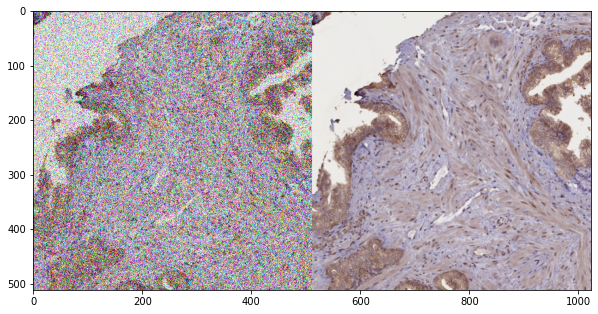

In [13]:
fn = np.random.choice(COMBINED_DF.fnames.values)
d = {IMAGE:fn,LABEL:fn}
d = get_noisy_transforms()(d)
plot_image_noisy_image(d[IMAGE], d[LABEL])

In [14]:
x = torch.rand([16, 1, 16, 16])
y = x * 0.75
data_range = x.max().unsqueeze(0)
monai.losses.ssim_loss.SSIMLoss()(x,y,data_range)

tensor(0.0781)

In [15]:
class MAELOSS(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.l = torch.nn.L1Loss()
        self.s = torch.sigmoid
    def forward(self, y_hat, y): return self.l(self.s(y_hat), y)
y_hat, y = torch.rand(2, 3, 256, 256), torch.rand(2, 3, 256, 256)
MAELOSS()(y_hat, y)

tensor(0.2687)

In [16]:
class SSIMLossWrapper(torch.nn.Module):
    def __init__(self, sigmoid=True, include_background=True):
        super().__init__()
        self.l = monai.losses.ssim_loss.SSIMLoss(spatial_dims=2)
        self.s = torch.sigmoid
        self.apply_sigmoid = sigmoid
        self.include_background = include_background
    def forward(self, y_hat, y):
        loss = 0
        for channel in range(y_hat.shape[1]):
            if not self.include_background and channel == 0: continue
            if self.apply_sigmoid: p = self.s(y_hat[:,channel].unsqueeze(1))
            else: p = y_hat[:,channel].unsqueeze(1)
            t = y[:,channel].unsqueeze(1)
            dr = p.max().unsqueeze(0) - p.min().unsqueeze(0)
            if self.include_background: loss += self.l(p, t, dr) / y_hat.shape[1]
            else: loss += self.l(p, t, dr) / (y_hat.shape[1] - 1)
        return loss
SSIMLossWrapper(sigmoid=False)(y_hat, y), SSIMLossWrapper(sigmoid=True)(y_hat, y), SSIMLossWrapper(sigmoid=False, include_background=False)(y_hat, y),
#SSIMLossWrapper(sigmoid=False)(torch.ones([1,1,10,10])/2, torch.ones([1,1,10,10])/2)

(tensor(0.9941), tensor(0.9993), tensor(0.9946))

In [17]:
class CombinedLoss(torch.nn.Module):
    def __init__(self, sigmoid=True):
        super().__init__()
        self.ssim = SSIMLossWrapper(sigmoid=sigmoid)
        self.mae = MAELOSS()
    def forward(self, y_hat, y): 
        return self.ssim(y_hat, y) + self.mae(y_hat, y)
CombinedLoss()(y_hat, y)

tensor(1.2679)

In [18]:
class SSIMGDICEFOCAL(torch.nn.Module):
    def __init__(self, sigmoid=True, include_background=True):
        super().__init__()
        self.ssim = SSIMLossWrapper(sigmoid=sigmoid, include_background=include_background)
        self.gdice_focal = monai.losses.GeneralizedDiceFocalLoss(softmax=True)
    def forward(self, y_hat, y):
        return self.gdice_focal(y_hat, y) + self.ssim(y_hat, y) 
SSIMGDICEFOCAL()(y_hat, y), SSIMGDICEFOCAL(sigmoid=False, include_background=True)(y_hat, y), SSIMGDICEFOCAL(sigmoid=True, include_background=False)(y_hat, y)

(tensor(1.7640), tensor(1.7588), tensor(1.7642))

In [19]:
def alb_wrapper(arr, f):
    datatype = arr.dtype
    arr = torch.einsum("cwh->whc", arr) * 255.
    arr = f(image=arr.numpy().astype(np.uint8))["image"]
    arr = torch.Tensor(arr).to(datatype) / 255.
    return torch.einsum("whc->cwh", arr)
huesat = partial(alb_wrapper, f=A.HueSaturationValue(
    p=1, 
    hue_shift_limit=80,
    sat_shift_limit=80, 
    val_shift_limit=80, 
    always_apply=True))

In [20]:
def get_load_transforms() -> monai.transforms.Compose:
    return monai.transforms.Compose([
        monai.transforms.Lambdad((IMAGE,), id2image),
        monai.transforms.TransposeD((IMAGE,), (2, 0, 1)),
        monai.transforms.Lambdad((LABEL,), id2mask),
        monai.transforms.AddChanneld((LABEL,)),
        monai.transforms.AsDiscreted((LABEL,), to_onehot=2),
        monai.transforms.ScaleIntensityD((IMAGE,)),
    ])

def get_train_transforms() -> monai.transforms.Compose:
    return monai.transforms.Compose([
        *get_load_transforms().transforms,

        monai.transforms.CenterSpatialCropd(KEYS,roi_size=CROP_SIZE),
        
        monai.transforms.RandSpatialCropd(KEYS, roi_size=MIN_CROP_SIZE, max_roi_size=CROP_SIZE),
        monai.transforms.ResizeD(KEYS, spatial_size=IMAGE_SIZE, mode=("bilinear", "nearest-exact")),
        monai.transforms.RandRotated(KEYS, range_x=3.14159, prob=1, padding_mode="reflection"),
        monai.transforms.Lambdad((IMAGE,), huesat),
        
        monai.transforms.RandAdjustContrastd((IMAGE,), prob=TRANSFORM_PROB),
        monai.transforms.RandGaussianNoised((IMAGE,), prob=TRANSFORM_PROB),
        monai.transforms.RandCoarseShuffled((IMAGE,), 
            holes=2, 
            max_holes=15, 
            spatial_size=(int(IMAGE_SIZE[0]*0.01), int(IMAGE_SIZE[1]*0.01)), 
            max_spatial_size=(int(IMAGE_SIZE[0]*0.1), int(IMAGE_SIZE[1]*0.1)),  
            prob=TRANSFORM_PROB),

        monai.transforms.AsDiscreteD((LABEL,), threshold=0.5),
        monai.transforms.EnsureTypeD(KEYS)
])

def get_valid_transforms() -> monai.transforms.Compose:
    return monai.transforms.Compose([
        monai.transforms.Lambdad((IMAGE,), id2image),
        monai.transforms.TransposeD((IMAGE,), (2, 0, 1)),
        monai.transforms.Lambdad((LABEL,), id2mask),
        monai.transforms.AddChanneld((LABEL,)),
        monai.transforms.AsDiscreted((LABEL,), to_onehot=2),
        monai.transforms.ScaleIntensityD((IMAGE,)),
        monai.transforms.ResizeD(KEYS, spatial_size=IMAGE_SIZE, mode=("bilinear", "nearest-exact")),
        monai.transforms.RandRotated(KEYS, range_x=3.14159, prob=1, padding_mode="reflection"),
        monai.transforms.AsDiscreteD((LABEL,), threshold=0.5),
        monai.transforms.EnsureTypeD(KEYS)
])

def get_test_transforms() -> monai.transforms.Compose:
    return monai.transforms.Compose([
        monai.transforms.Lambdad((IMAGE,), id2image),
        monai.transforms.TransposeD((IMAGE,), (2, 0, 1)),
        monai.transforms.Lambdad((LABEL,), id2mask),
        monai.transforms.AddChanneld((LABEL,)),
        monai.transforms.AsDiscreted((LABEL,), to_onehot=2),
        monai.transforms.ScaleIntensityD((IMAGE,)),
        monai.transforms.ResizeD(KEYS, spatial_size=IMAGE_SIZE, mode=("bilinear", "nearest-exact")),
        monai.transforms.EnsureTypeD(KEYS)
])

In [21]:
def get_best_threshold(model, dl, metric_func):
    thresholds = torch.linspace(0.1, 0.9, 17)
    res = []
    for t in thresholds: res.append((t.detach().cpu().item(), test_model(model, dl, threshold=t, metric_func=metric_func)))
    return sorted(res, key=lambda tpl: tpl[1], reverse=True)[0]

In [29]:
def empty_cache_dir():
    cache_dir = "../data/cache_dir/additional_images/"
    os.system(f"rm -rf {cache_dir}")

In [ ]:
metrics_log = {"organ": [], "threshold":[], "train_dice": [], "valid_dice": [], "test_dice": []}

for organ in TRAIN_DF.organ.unique():
    
    # Decoder denoising pretraining:
    add_organ = organ if organ != "largeintestine" else "colon"
    ADDITIONAL_IMAGES = get_image_files("../data/additional_images/")
    ADDITIONAL_IMAGES = L([fn for fn in ADDITIONAL_IMAGES if add_organ in fn.stem or organ in str(fn)])
    add_idx = L(range(len(ADDITIONAL_IMAGES)))
    np.random.shuffle(add_idx)
    cutoff = int(0.8 * len(add_idx))
    train_idx = add_idx[:cutoff]
    valid_idx = add_idx[cutoff:]
    ADD_TRAIN = ADDITIONAL_IMAGES[train_idx]
    ADD_VALID = ADDITIONAL_IMAGES[valid_idx]

    data_dicts = {
        "train": {i: {IMAGE: fn, LABEL: fn} for i, fn in enumerate(ADD_TRAIN)},
        "valid": {i: {IMAGE: fn, LABEL: fn} for i, fn in enumerate(ADD_VALID)}
    }
    train_ds = monai.data.PersistentDataset(data_dicts["train"], transform=get_noisy_transforms(), cache_dir="../data/cache_dir/additional_images")
    valid_ds = monai.data.PersistentDataset(data_dicts["valid"], transform=get_noisy_transforms(), cache_dir="../data/cache_dir/additional_images")
    train_dl = monai.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    valid_dl = monai.data.DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False)
    loaders = {"train": train_dl, "valid": valid_dl}

    model = smp.Unet(
        encoder_name=ENCODER,        
        encoder_weights="imagenet",     
        in_channels=3,                  
        classes=3,  
    )

    criterion = SSIMLossWrapper()
    optimizer = Lookahead(torch.optim.RAdam([*model.decoder.parameters(), *model.segmentation_head.parameters()], lr=LR))
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 5)
    callbacks = [
        catalyst.dl.OptimizerCallback(
            metric_key="loss", 
            accumulation_steps=4),
        catalyst.dl.EarlyStoppingCallback(
            patience=EARLY_STOP_PATIENCE, 
            loader_key="valid", 
            metric_key="loss",
            min_delta=1e-3,
            minimize=True)
    ]

    runner = catalyst.dl.SupervisedRunner(
        input_key=IMAGE, 
        output_key="logits", 
        target_key=LABEL, 
        loss_key="loss"
    )

    runner.train(
        model=model,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        loaders=loaders,
        num_epochs=5,
        callbacks=callbacks,
        logdir=LOG_DIR/f"{organ}_denoise",
        valid_loader="valid",
        valid_metric="loss",
        minimize_valid_metric=True,
        verbose=True,
        timeit=False,
        load_best_on_end=False
    )
    # Not enough disk space to keep caches
    empty_cache_dir()

    # tranfer learning
    organ_train_test_df = split_df_train_test(TRAIN_DF[TRAIN_DF.organ==organ],"is_test", test_pct=0.1)
    organ_testset_df = organ_train_test_df[organ_train_test_df.is_test].copy()
    organ_train_valid_df = organ_train_test_df[~organ_train_test_df.is_test].copy()
    organ_train_valid_df = split_df_train_test(organ_train_valid_df, "is_valid", seed=92)
    assert len(organ_testset_df.organ.unique()) == 1
    assert len(organ_train_valid_df.organ.unique()) == 1
    del organ_train_test_df

    train_ids = organ_train_valid_df[~organ_train_valid_df.is_valid].id.values
    valid_ids = organ_train_valid_df[organ_train_valid_df.is_valid].id.values
    test_ids = organ_testset_df.id.values
    assert len(set(train_ids).intersection(set(valid_ids))) == 0
    assert len(set(train_ids).intersection(set(test_ids))) == 0
    assert len(set(valid_ids).intersection(set(test_ids))) == 0

    data_dicts = {
        "train": {i: {IMAGE: fid, LABEL: fid} for i, fid in enumerate(train_ids)},
        "valid": {i: {IMAGE: fid, LABEL: fid} for i, fid in enumerate(valid_ids)},
        "test":  {i: {IMAGE: fid, LABEL: fid} for i, fid in enumerate(test_ids)}
    }

    train_ds = monai.data.CacheDataset(data_dicts["train"], transform=get_train_transforms())
    valid_ds = monai.data.CacheDataset(data_dicts["valid"], transform=get_valid_transforms())
    test_ds  = monai.data.CacheDataset(data_dicts["test"],  transform=get_test_transforms())

    train_dl = monai.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    valid_dl = monai.data.DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False)
    test_dl  = monai.data.DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

    loaders = {"train": train_dl, "valid": valid_dl}

    model.segmentation_head = torch.nn.Conv2d(16, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    model = model.to(DEVICE)

    criterion = monai.losses.GeneralizedDiceFocalLoss(softmax=True)
    optimizer = Lookahead(torch.optim.RAdam(model.segmentation_head.parameters(), lr=LR/100))
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 5)

    dice_func = partial(
        calc_metric, 
        metric_func=monai.metrics.DiceMetric(include_background=False, reduction="mean"))

    callbacks = [
        catalyst.dl.FunctionalMetricCallback(
        input_key="logits",
        target_key=LABEL,
        metric_fn=dice_func,
        metric_key="dice"
        ),
        catalyst.dl.OptimizerCallback(
            metric_key="loss", 
            accumulation_steps=ACCUM_STEPS),
        catalyst.dl.EarlyStoppingCallback(
            patience=EARLY_STOP_PATIENCE, 
            loader_key="valid", 
            metric_key="loss",
            min_delta=1e-3,
            minimize=True)
    ]

    runner = catalyst.dl.SupervisedRunner(
        input_key=IMAGE, 
        output_key="logits", 
        target_key=LABEL, 
        loss_key="loss"
    )

    runner.train(
        model=model,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        loaders=loaders,
        num_epochs=5,
        callbacks=callbacks,
        logdir=LOG_DIR/f"{organ}_transfered",
        valid_loader="valid",
        valid_metric="loss",
        minimize_valid_metric=True,
        verbose=False,
        timeit=False,
        load_best_on_end=True
    )
    
    # finetuning

    criterion = monai.losses.GeneralizedDiceFocalLoss(softmax=True)
    optimizer = Lookahead(torch.optim.RAdam(model.parameters(), lr=LR))
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 5)

    dice_func = partial(
        calc_metric, 
        metric_func=monai.metrics.DiceMetric(include_background=False, reduction="mean"))

    callbacks = [
        catalyst.dl.FunctionalMetricCallback(
        input_key="logits",
        target_key=LABEL,
        metric_fn=dice_func,
        metric_key="dice"
        ),
        catalyst.dl.OptimizerCallback(
            metric_key="loss", 
            accumulation_steps=ACCUM_STEPS),
        catalyst.dl.EarlyStoppingCallback(
            patience=EARLY_STOP_PATIENCE, 
            loader_key="valid", 
            metric_key="loss",
            min_delta=1e-3,
            minimize=True)
    ]

    runner = catalyst.dl.SupervisedRunner(
        input_key=IMAGE, 
        output_key="logits", 
        target_key=LABEL, 
        loss_key="loss"
    )

    runner.train(
        model=model,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        loaders=loaders,
        num_epochs=EPOCHS,
        callbacks=callbacks,
        logdir=LOG_DIR/f"{organ}_finetuned",
        valid_loader="valid",
        valid_metric="loss",
        minimize_valid_metric=True,
        verbose=False,
        timeit=False,
        load_best_on_end=True
    )

    dice_metric = monai.metrics.DiceMetric(
        include_background=False, 
        reduction="mean")

    best_threshold, test_dice = get_best_threshold(model, test_dl, dice_metric) 

    train_dice = test_model(model, train_dl, metric_func=dice_metric)
    valid_dice = test_model(model, valid_dl, metric_func=dice_metric)

    metrics_log["organ"].append(organ)
    metrics_log["threshold"].append(best_threshold)
    metrics_log["train_dice"].append(train_dice)
    metrics_log["valid_dice"].append(valid_dice)
    metrics_log["test_dice"].append(test_dice)
    save_df(metrics_log, LOG_DIR/"metrics.csv", replace=True)

print("Done.")

## End of submission model training